This file is a series of initial experiments intended to demonstrate how computational methods such as CALPHAD and other composition and temperature space mappings can provide valuable insights into how to optimise properties both to meet the specifications but also to improve the feasibility of production in the lab.

Contents:


In [ ]:
# Alloy design screening template for Fe–Cr–C–X–N  (X ∈ {Mo, Ni, Mn, Si})
# Includes Nitrogen in the grid and PREN; treats Si as a substitutional X.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Database, Model, variables as v, equilibrium

# -----------------------------
# 1) User-editable assumptions
# -----------------------------

# Composition grids (wt %)
C_values   = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]     # carbon
Cr_values  = [11.0, 12.0, 13.0, 14.0, 15.0]                                   # chromium
X_values   = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]                                   # third element content (Si realistic 0–2 wt%)
N_values   = [0.00, 0.05, 0.10, 0.15]                                         # nitrogen

# Which X elements to include
X_elements = ["Mo", "Ni", "Mn", "Si"]   # choose any subset of ["Mo","Ni","Mn","Si"]

# Room-temperature "service" temperature for equilibrium filtering (placeholder)
service_temperature_C = 20

# Cost assumptions (USD/kg) — placeholders; edit to match your local quotes
# Note: The "cost" of adding N in practice is a processing cost (gas/pressure) not per-kg N metal.
# Use a small proxy here so PREN gains from N don't look "free".
cost_usd_per_kg = {
    "Fe": 7.9,
    "C":  0.15,
    "Cr": 7.0,
    "Mo": 10.0,
    "Ni": 9.0,
    "Mn": 1.8,
    "Si": 2.0,
    "N":  0.15,
}

# CO2 factors (kgCO2e/kg element) — placeholders
co2_per_kg = {
    "Fe": 2.0,
    "C":  3.0,
    "Cr": 6.0,
    "Mo": 20.0,
    "Ni": 9.0,
    "Mn": 3.0,
    "Si": 4.0,
    "N":  0.5,   # proxy
}

density_proxy = 7.8  # g/cc (not used directly)

# -----------------------------
# 2) Helper functions
# -----------------------------

def Ms_andrews(C_wt, Cr_wt, Ni_wt=0.0, Mn_wt=0.0, Mo_wt=0.0, N_wt=0.0, include_N_term=False):
    """
    Andrews-type Ms equation (°C):
    Ms ≈ 539 − 423C − 30.4Mn − 17.7Ni − 12.1Cr − 7.5Mo
    Classic form has no N or Si term. If you want to test an empirical N penalty, set include_N_term=True.
    """
    Ms = 539 - 423*C_wt - 30.4*Mn_wt - 17.7*Ni_wt - 12.1*Cr_wt - 7.5*Mo_wt
    if include_N_term:
        Ms -= 30.0 * N_wt   # simple empirical penalty (tunable); False by default
    return Ms

def pren(Cr_wt, Mo_wt=0.0, N_wt=0.0, W_wt=0.0):
    """PREN ≈ %Cr + 3.3(%Mo + 0.5%W) + 16%N  (Si does not enter PREN)"""
    return Cr_wt + 3.3*(Mo_wt + 0.5*W_wt) + 16.0*N_wt

def cost_per_kg(alloy):
    """Sum per-kg element costs by wt%; Fe is balance."""
    Fe_wt = 100.0 - sum(v for k, v in alloy.items() if k != "Fe")
    total = (Fe_wt/100.0) * cost_usd_per_kg["Fe"]
    for el, wt in alloy.items():
        if el == "Fe" or wt == 0:
            continue
        total += (wt/100.0) * cost_usd_per_kg.get(el, 0.0)
    return total

def co2_per_kg_alloy(alloy):
    Fe_wt = 100.0 - sum(v for k, v in alloy.items() if k != "Fe")
    total = (Fe_wt/100.0) * co2_per_kg["Fe"]
    for el, wt in alloy.items():
        if el == "Fe" or wt == 0:
            continue
        total += (wt/100.0) * co2_per_kg.get(el, 0.0)
    return total

def solid_solution_strength_proxy(alloy):
    """Δσ_ss ≈ Σ k_i * sqrt(c_i)   (proxy; wt% basis; illustrative k_i)"""
    k = {"Cr": 35.0, "Mo": 120.0, "Ni": 20.0, "Mn": 25.0, "Si": 20.0, "C": 250.0, "N": 180.0}
    s = 0.0
    for el, wt in alloy.items():
        if el in k and wt > 0:
            s += k[el] * math.sqrt(wt)
    return s  # MPa (proxy)

# -----------------------------
# 3) Generate grid
# -----------------------------
rows = []
for X in X_elements:
    for C in C_values:
        for Cr in Cr_values:
            for N in N_values:
                for x_wt in X_values:
                    comp = {"C": C, "Cr": Cr, "N": N, X: x_wt}
                    Ms = Ms_andrews(
                        C_wt=C, Cr_wt=Cr,
                        Ni_wt=comp.get("Ni", 0.0),
                        Mn_wt=comp.get("Mn", 0.0),
                        Mo_wt=comp.get("Mo", 0.0),
                        N_wt=N,
                        include_N_term=False  # classic Andrews form
                    )
                    PREN = pren(Cr_wt=Cr, Mo_wt=comp.get("Mo", 0.0), N_wt=N)
                    cost = cost_per_kg(comp)
                    co2  = co2_per_kg_alloy(comp)
                    dss  = solid_solution_strength_proxy(comp)

                    Fe_balance = 100.0 - (C + Cr + N + x_wt)

                    rows.append({
                        "X_element": X,
                        "C_wt%": C,
                        "Cr_wt%": Cr,
                        "N_wt%": N,
                        f"{X}_wt%": x_wt,
                        "Fe_wt% (balance)": Fe_balance,
                        "Ms_C": Ms,
                        "PREN": PREN,
                        "Strength_proxy_MPa": dss,
                        "Cost_USD_per_kg": round(cost, 3),
                        "KgCO2e_per_kg": round(co2, 3),
                        "Service_T_C (info)": service_temperature_C,
                        "Ms_ok_(>=200C)": Ms >= 200.0,
                        "Fe_balance_ok_(>80%)": Fe_balance > 80.0
                    })

df = pd.DataFrame(rows)

# Ensure missing X columns appear
for col in ["Mo_wt%","Ni_wt%","Mn_wt%","Si_wt%"]:
    if col not in df.columns:
        df[col] = 0.0

# Reorder columns
cols = ["X_element","C_wt%","Cr_wt%","N_wt%","Mo_wt%","Ni_wt%","Mn_wt%","Si_wt%",
        "Fe_wt% (balance)","Ms_C","PREN","Strength_proxy_MPa",
        "Cost_USD_per_kg","KgCO2e_per_kg",
        "Ms_ok_(>=200C)","Fe_balance_ok_(>80%)","Service_T_C (info)"]
df = df[cols]

# Save & preview
csv_path = "./FeCrC_XN_screening_grid.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved: {csv_path}")
df.head(20)


CSV saved: ./FeCrC_XN_screening_grid.csv


X_element  C_wt%  Cr_wt%  N_wt%  Mo_wt%  Ni_wt%  Mn_wt%  Si_wt%  \
0         Mo    0.1    11.0   0.00     0.0     NaN     NaN     NaN   
1         Mo    0.1    11.0   0.00     0.5     NaN     NaN     NaN   
2         Mo    0.1    11.0   0.00     1.0     NaN     NaN     NaN   
3         Mo    0.1    11.0   0.00     1.5     NaN     NaN     NaN   
4         Mo    0.1    11.0   0.00     2.0     NaN     NaN     NaN   
5         Mo    0.1    11.0   0.00     2.5     NaN     NaN     NaN   
6         Mo    0.1    11.0   0.05     0.0     NaN     NaN     NaN   
7         Mo    0.1    11.0   0.05     0.5     NaN     NaN     NaN   
8         Mo    0.1    11.0   0.05     1.0     NaN     NaN     NaN   
9         Mo    0.1    11.0   0.05     1.5     NaN     NaN     NaN   
10        Mo    0.1    11.0   0.05     2.0     NaN     NaN     NaN   
11        Mo    0.1    11.0   0.05     2.5     NaN     NaN     NaN   
12        Mo    0.1    11.0   0.10     0.0     NaN     NaN     NaN   
13        Mo    0.1    11.0   0.10     0.5     NaN     NaN     NaN   
14        Mo    0.1    11.0   0.10     1.0     NaN     NaN     NaN   
15        Mo    0.1    11.0   0.10     1.5     NaN     NaN     NaN   
16        Mo    0.1    11.0   0.10     2.0     NaN     NaN     NaN   
17        Mo    0.1    11.0   0.10     2.5     NaN     NaN     NaN   
18        Mo    0.1    11.0   0.15     0.0     NaN     NaN     NaN   
19        Mo    0.1    11.0   0.15     0.5     NaN     NaN     NaN   

    Fe_wt% (balance)    Ms_C   PREN  Strength_proxy_MPa  Cost_USD_per_kg  \
0              88.90  363.60  11.00          195.138809            1.393   
1              88.40  359.85  12.65          279.991623            1.439   
2              87.90  356.10  14.30          315.138809            1.486   
3              87.40  352.35  15.95          342.108194            1.532   
4              86.90  348.60  17.60          364.844437            1.579   
5              86.40  344.85  19.25          384.875469            1.625   
6              88.85  363.60  11.80          235.388033            1.392   
7              88.35  359.85  13.45          320.240847            1.439   
8              87.85  356.10  15.10          355.388033            1.485   
9              87.35  352.35  16.75          382.357417            1.532   
10             86.85  348.60  18.40          405.093660            1.578   
11             86.35  344.85  20.05          425.124692            1.625   
12             88.80  363.60  12.60          252.059807            1.392   
13             88.30  359.85  14.25          336.912621            1.439   
14             87.80  356.10  15.90          372.059807            1.485   
15             87.30  352.35  17.55          399.029192            1.532   
16             86.80  348.60  19.20          421.765435            1.578   
17             86.30  344.85  20.85          441.796467            1.625   
18             88.75  363.60  13.40          264.852509            1.392   
19             88.25  359.85  15.05          349.705323            1.439   

    KgCO2e_per_kg  Ms_ok_(>=200C)  Fe_balance_ok_(>80%)  Service_T_C (info)  
0           2.441            True                  True                  20  
1           2.531            True                  True                  20  
2           2.621            True                  True                  20  
3           2.711            True                  True                  20  
4           2.801            True                  True                  20  
5           2.891            True                  True                  20  
6           2.440            True                  True                  20  
7           2.530            True                  True                  20  
8           2.620            True                  True                  20  
9           2.710            True                  True                  20  
10          2.800            True                  True                  20  

In [107]:
# Load your existing screening grid
df = pd.read_csv("FeCrC_XN_screening_grid.csv")

# --- Metallurgical sanity filters (N forced to zero) ---
keep = (
    (df["Fe_balance_ok_(>80%)"] == True)
    & (df["Ms_ok_(>=200C)"] == True)
    & (df["C_wt%"].between(0.10, 0.40))
    & (df["Cr_wt%"].between(11.0, 15.0))
    & (df["N_wt%"] == 0.00)  # N = 0 only
)

dff = df[keep].copy()

# --- Scoring formula (same as your main script) ---
dff["score_noN"] = (
    dff["PREN"]
    + 0.1*(dff["Ms_C"] - 200)
    + 0.005*dff["Strength_proxy_MPa"]
    - 0.7*dff["Cost_USD_per_kg"]
)

# --- Top 3 per X (Mo, Ni, Mn, Si) ---
finalists_noN = (
    dff.sort_values(["X_element","score_noN"], ascending=[True, False])
       .groupby("X_element")
       .head(3)
       .reset_index(drop=True)
)

cols_show = ["X_element","C_wt%","Cr_wt%","N_wt%","Mo_wt%","Ni_wt%","Mn_wt%","Si_wt%",
             "Ms_C","PREN","Strength_proxy_MPa","Cost_USD_per_kg","score_noN"]

# Display and save as a new file
print(finalists_noN[cols_show].to_string(index=False))
finalists_noN.to_csv("shortlist_candidates_noN_separate.csv", index=False)

X_element  C_wt%  Cr_wt%  N_wt%  Mo_wt%  Ni_wt%  Mn_wt%  Si_wt%   Ms_C  PREN  Strength_proxy_MPa  Cost_USD_per_kg  score_noN
       Mn    0.1    11.0    0.0     NaN     NaN     0.0     NaN 363.60 11.00          195.138809            1.393  27.360594
       Mn    0.1    12.0    0.0     NaN     NaN     0.0     NaN 351.50 12.00          200.300498            1.455  27.133002
       Mn    0.1    13.0    0.0     NaN     NaN     0.0     NaN 339.40 13.00          205.251236            1.518  26.903656
       Mo    0.1    11.0    0.0     2.5     NaN     NaN     NaN 344.85 19.25          384.875469            1.625  34.521877
       Mo    0.1    12.0    0.0     2.5     NaN     NaN     NaN 332.75 20.25          390.037158            1.688  34.293586
       Mo    0.1    13.0    0.0     2.5     NaN     NaN     NaN 320.65 21.25          394.987896            1.751  34.064239
       Ni    0.1    11.0    0.0     NaN     0.0     NaN     NaN 363.60 11.00          195.138809            1.393  27.360594


In [ ]:
df = pd.read_csv("FeCrC_XN_screening_grid.csv")

# --- Metallurgical sanity filters (tune to your brief) ---
keep = (
    (df["Fe_balance_ok_(>80%)"] == True)
    & (df["Ms_ok_(>=200C)"] == True)
    & (df["C_wt%"].between(0.10, 0.40))         # corrosion + martensite friendly
    & (df["Cr_wt%"].between(11.0, 15.0))        # your range
    & (df["N_wt%"].between(0.00, 0.25))         # realistic N
)

dff = df[keep].copy()

# --- Score (simple, interpretable): high PREN, high Ms, high Strength, low cost ---
dff["score"] = (
    dff["PREN"]
    + 0.1*(dff["Ms_C"] - 200)
    + 0.005*dff["Strength_proxy_MPa"]
    - 0.7*dff["Cost_USD_per_kg"]
)


# Top 3 per X (Mo, Ni, Mn, Si)
finalists = (
    dff.sort_values(["X_element","score"], ascending=[True, False])
       .groupby("X_element")
       .head(3)
       .reset_index(drop=True)
)

cols_show = ["X_element","C_wt%","Cr_wt%","N_wt%","Mo_wt%","Ni_wt%","Mn_wt%","Si_wt%",
             "Ms_C","PREN","Strength_proxy_MPa","Cost_USD_per_kg","score"]
print(finalists[cols_show].to_string(index=False))
finalists.to_csv("shortlist_candidates.csv", index=False)

X_element  C_wt%  Cr_wt%  N_wt%  Mo_wt%  Ni_wt%  Mn_wt%  Si_wt%   Ms_C  PREN  Strength_proxy_MPa  Cost_USD_per_kg     score
       Mn    0.1    11.0   0.15     NaN     NaN     0.0     NaN 363.60 13.40          264.852509            1.392 30.109863
       Mn    0.1    12.0   0.15     NaN     NaN     0.0     NaN 351.50 14.40          270.014198            1.455 29.881571
       Mn    0.1    13.0   0.15     NaN     NaN     0.0     NaN 339.40 15.40          274.964936            1.518 29.652225
       Mo    0.1    11.0   0.15     2.5     NaN     NaN     NaN 344.85 21.65          454.589169            1.625 37.270446
       Mo    0.1    12.0   0.15     2.5     NaN     NaN     NaN 332.75 22.65          459.750858            1.688 37.042154
       Mo    0.1    13.0   0.15     2.5     NaN     NaN     NaN 320.65 23.65          464.701596            1.751 36.812808
       Ni    0.1    11.0   0.15     NaN     0.0     NaN     NaN 363.60 13.40          264.852509            1.392 30.109863
       N

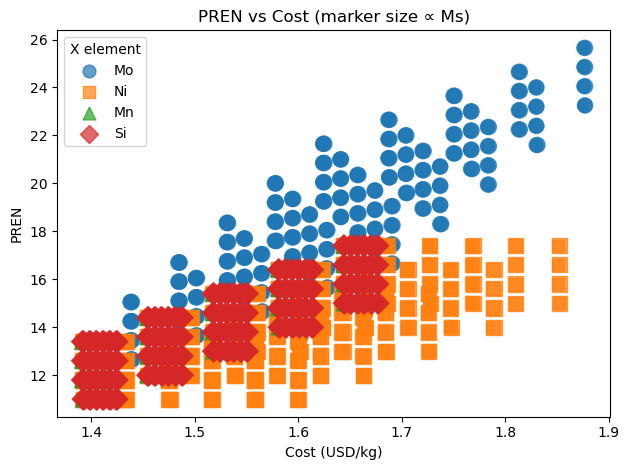

In [109]:
cmap = {"Mo":"o","Ni":"s","Mn":"^","Si":"D"}
plt.figure()
for x in ["Mo","Ni","Mn","Si"]:
    dd = dff[dff["X_element"]==x]
    plt.scatter(dd["Cost_USD_per_kg"], dd["PREN"], 
                s=np.clip((dd["Ms_C"]-150), 10, 120), marker=cmap[x], label=x, alpha=0.7)
plt.xlabel("Cost (USD/kg)"); plt.ylabel("PREN")
plt.title("PREN vs Cost (marker size ∝ Ms)")
plt.legend(title="X element")
plt.tight_layout(); plt.savefig("pren_vs_cost.png", dpi=220)


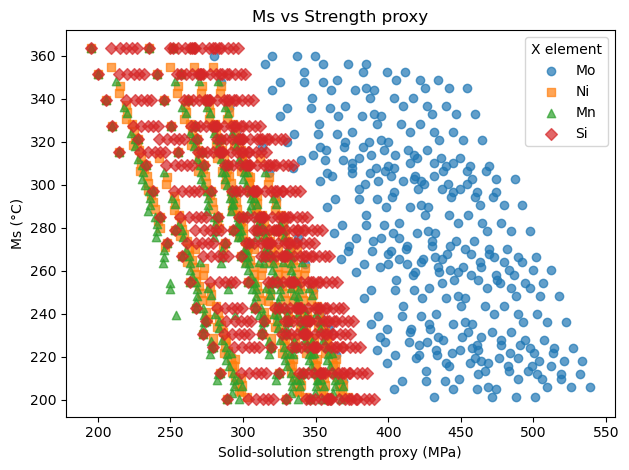

In [110]:
plt.figure()
for x in ["Mo","Ni","Mn","Si"]:
    dd = dff[dff["X_element"]==x]
    plt.scatter(dd["Strength_proxy_MPa"], dd["Ms_C"], marker=cmap[x], label=x, alpha=0.7)
plt.xlabel("Solid-solution strength proxy (MPa)")
plt.ylabel("Ms (°C)")
plt.title("Ms vs Strength proxy")
plt.legend(title="X element")
plt.tight_layout(); plt.savefig("ms_vs_strength.png", dpi=220)


In [111]:
db = Database('iron4cd.TDB')
print(db.elements)
print(list(db.phases.keys()))


{'MO', 'MG', 'TI', 'V', 'C', 'SI', 'CU', 'VA', 'CR', 'N', 'MN', 'NI', 'NB', 'FE'}
['LIQUID', 'FCC_A1', 'A1_FCC', 'FCC_4SL', 'BCC_A2', 'A2_BCC', 'B2_BCC', 'HCP_A3', 'CBCC_A12', 'CUB_A13', 'DIAMOND_A4', 'GRAPHITE_A9', 'CEMENTITE_D011', 'CHI_A12', 'CR3C2_D510', 'CR3MN5', 'CRNI2_C11B', 'CR3NI5SI2', 'CR5NI5SI3', 'CR3SI_A15', 'CR5SI3_D8M', 'CRSI2_C40', 'CR2VC2', 'CUMG2_CB', 'CU33SI7_A13', 'CU33SI7_HT', 'CU15SI4_D86', 'CU3SI_LT', 'CU3SI_MT', 'CU3SI_HT', 'CU4TI1', 'CU2TI', 'CU3TI2', 'CU4TI3', 'CUTI_B11', 'CUTI2_C11B', 'FECN_CHI', 'FE4N_L1', 'FENBSI2', 'FE4NB4SI7', 'FENBSI1', 'FENB2SI2', 'FE3NB4SI5', 'FENB4SI', 'FE2SI', 'FESI2_H', 'FESI2_L', 'FE8SI2C', 'KSI_CARBIDE', 'C14_LAVES', 'C15_LAVES', 'C36_LAVES', 'MC_ETA', 'MC_SHP', 'M5C2', 'M6C_E93', 'M7C3_D101', 'M23C6_D84', 'M5SI3_D88', 'M5SI3_D8M', 'M4SI3', 'MSI_B20', 'MG2C3', 'MGC2', 'MG3N2_D53', 'MG2NI', 'MG2SI_C1', 'MN3N2', 'MN6N5', 'MN6SI', 'MN9SI2', 'MN3SI', 'MN11SI19', 'MN4TI', 'MN3TI', 'MNTI_ALPHA', 'MNTI_BETA', 'MONI', 'MOSI2_C11B', 'MO3SI_

/Users/thomasfish/miniforge3/envs/alloydesign/lib/python3.10/site-packages/pycalphad/io/tdb.py:287: UserWarning: Type definitions using IF/THEN logic is not supported
  warnings.warn("Type definitions using IF/THEN logic is not supported")


In [112]:
# -----------------------
# USER SETTINGS
# -----------------------
TDB_PATH = r"./iron4cd.TDB"                 # <-- set if needed
SHORTLIST_CSV = "shortlist_candidates.csv"  # nitrogen-included shortlist
OUTDIR = "calphad_outputs_2"                # (6) save in a new directory reflecting fixed contents

T_AUST_C = 900.0               # isothermal section temperature (°C)
VERT_SECTION_C = 0.10          # legacy var; plotting now uses FIXED["C"]
VERT_SECTION_CR = 13.0         # fixed Cr (wt%) for vertical section
X_SWEEP_WT = np.linspace(0.0, 2.0, 161)  # 0→2 wt% in 0.0125% steps

# modest coarse mesh helps convergence speed
CALC_OPTS = {"pdens": 300}

# (1) FIXED composition for all diagrams (wt%)
FIXED = {
    "C": 0.10,   # wt%
    "N": 0.15,   # wt%
}

# Target systems for Mo and Ni runs
# (IMPORTANT) include N in components since it's now fixed and present
SYSTEMS = {
    "Mo": dict(components=["FE", "CR", "C", "N", "MO"], X_symbol="MO"),
    "Ni": dict(components=["FE", "CR", "C", "N", "NI"], X_symbol="NI"),
    "Si": dict(components=["FE", "CR", "C", "N", "SI"], X_symbol="SI"),
    "Mn": dict(components=["FE", "CR", "C", "N", "MN"], X_symbol="MN"),
}

# Phase labels (aliases included for this DB)
# (5) Include common nitride phase names found in Fe–Cr–N systems (harmless if absent)
PHASES_OF_INTEREST = [
    # matrices
    "LIQUID",
    "FCC_A1", "A1_FCC",
    "BCC_A2", "A2_BCC",

    # intermetallics / sigma / laves
    "SIGMA_D8B",
    "CHI_A12",
    "C14_LAVES", "C15_LAVES", "C36_LAVES",

    # carbides
    "M23C6_D84", "M7C3_D101", "M6C_E93", "CEMENTITE_D011",

    # nitrides
    "CR2N", "FE4N_L1", "MN3N2",

    # (NEW) silicides & Mn–Si intermetallics (DB-dependent; harmless if absent)
    "FE3SI", "FE5SI3", "FESI2_H", "FESI2_L", "FESI",
    "CR3SI_A15", "CR5SI3_D8M", "CRSI2_C40",
    "MOSI2_C11B",
    "MN3SI", "MN5SI3", "MN11SI19", "MN6SI", "MN9SI2",
]

# Short, safe labels for colorbar (avoid long strings → matplotlib overflow)
PRETTY = {
    # Core structural + matrix phases
    "LIQUID": "Liq",
    "FCC_A1": "γ", "A1_FCC": "γ",
    "BCC_A2": "α/δ", "A2_BCC": "α/δ",

    # Intermetallics, sigma
    "SIGMA_D8B": "σ",
    "CHI_A12": "χ",
    "C14_LAVES": "C14", "C15_LAVES": "C15", "C36_LAVES": "C36",

    # Carbides
    "CEMENTITE_D011": "Fe₃C",
    "M23C6_D84": "M23C6",
    "M7C3_D101": "M7C3",
    "M6C_E93": "M6C",

    # Nitrides
    "CR2N": "Cr₂N",
    "FE4N_L1": "Fe₄N",
    "MN3N2": "Mn₃N₂",

    # (NEW) Mn-bearing carbides & silicides — common in Fe–Cr–Mn–C–Si systems
    "MN3SI": "Mn₃Si",
    "MN5SI3": "Mn₅Si₃",
    "MN11SI19": "Mn₁₁Si₁₉",
    "MN6SI": "Mn₆Si",
    "MN9SI2": "Mn₉Si₂",

    # (NEW) Si-bearing intermetallics & silicides
    "FE3SI": "Fe₃Si",
    "FE5SI3": "Fe₅Si₃",
    "FESI2_H": "FeSi₂(H)",
    "FESI2_L": "FeSi₂(L)",
    "FESI": "FeSi",
    "CR3SI_A15": "Cr₃Si",
    "CR5SI3_D8M": "Cr₅Si₃",
    "CRSI2_C40": "CrSi₂",
    "MOSI2_C11B": "MoSi₂",

    # Convenience aliases for clarity
    "MN": "Mn",
    "SI": "Si",
}

def pretty(name):
    s = PRETTY.get(str(name), str(name))
    # ensure short tick strings
    return s.split(":")[0][:12]

# -----------------------
# HELPERS
# -----------------------
# (2) Add nitrogen atomic weight
ATOMIC_WT = {
    "FE": 55.845,
    "CR": 51.9961,
    "C": 12.0107,
    "NI": 58.6934,
    "MO": 95.95,
    "N": 14.007,
    "MN": 54.938,  
    "SI": 28.0855
}


def wt_to_mole_fracs(wt_dict):
    """Return dict of X(element) in mole fraction from wt% dict (Fe balance)."""
    if "FE" not in wt_dict:
        total_other = sum(wt for _, wt in wt_dict.items())
        wt_dict = {"FE": 100.0 - total_other, **wt_dict}
    moles = {el: (wt/ATOMIC_WT[el]) for el, wt in wt_dict.items()}
    n_tot = sum(moles.values())
    return {el: moles[el]/n_tot for el in wt_dict.keys()}

# (3) Generalized condition builder that uses any fixed elements, plus one variable X
def conds_fixed_and_var_X(fixed_wt, x_symbol, x_wt):
    """
    Build pycalphad condition dict for given fixed wt% dict and one variable element (wt%).
    Returns {v.X(el): mole_fraction} for all non-Fe elements in wt_dict.
    """
    wt = dict(fixed_wt)
    wt[x_symbol] = x_wt
    xm = wt_to_mole_fracs(wt)  # keep zero-valued elements, Fe is added as balance inside
    # Build conditions for every element except Fe (which is balance)
    return {v.X(el): xm.get(el, 0.0) for el in xm if el != "FE"}

def get_phase_axis_and_names(eq):
    """Return (phase_dim_name, [phase_names_as_str]). Robust to DB/xarray variants."""
    NP = eq["NP"]
    dims = NP.dims
    coords = NP.coords
    # Try standard coords
    if "phase" in coords:
        phase_dim = "phase"
        names = [str(x) for x in coords["phase"].values.tolist()]
    elif "vertex" in coords and "Phase" in eq:
        phase_dim = "vertex"
        names = [str(x) for x in np.array(eq["Phase"].values, dtype=object).tolist()]
    else:
        phase_dim = dims[-1]
        try:
            names = [str(x) for x in np.array(eq["Phase"].values, dtype=object).tolist()]
        except Exception:
            names = [f"{phase_dim}_{i}" for i in range(NP.sizes[phase_dim])]
    return phase_dim, names

# -----------------------
# PLOTS
# -----------------------
def plot_vertical_section(db, system_tag, x_symbol, T_range=(700, 1300)):
    """
    Pseudo-binary: Fe–Cr–(C,N) fixed; sweep X (0→2 wt%) vs T.
    Saves: vertical_section_{system_tag}.png
    """
    comps = SYSTEMS[system_tag]["components"]
    # 1 °C spacing across the range
    Ts_C = np.arange(T_range[0], T_range[1] + 1, 1.0)  # e.g., 700–1300 → 601 points
    Ts_K = Ts_C + 273.15
    x_vals = X_SWEEP_WT

    phase_grid = np.empty((len(Ts_K), len(x_vals)), dtype=object)

    for j, wt_x in enumerate(x_vals):
        # (4) Use FIXED plus the vertical-section Cr for the current sweep
        fixed_here = {**FIXED, "CR": VERT_SECTION_CR}
        conds = conds_fixed_and_var_X(fixed_here, x_symbol, wt_x)
        cond = {v.T: Ts_K}
        cond.update(conds)

        eq = equilibrium(db, comps, PHASES_OF_INTEREST, cond, calc_opts=CALC_OPTS)
        NP = eq["NP"]
        phase_dim, ph_names = get_phase_axis_and_names(eq)

        # Per-temperature predominant phase
        for iT, Tk in enumerate(eq["T"].values):
            fr_da = NP.sel(T=Tk)
            if phase_dim not in fr_da.dims:
                fr_da = fr_da.expand_dims({phase_dim: len(ph_names)})
            fr_da = fr_da.transpose(..., phase_dim)
            fr = np.asarray(fr_da.values)
            fr_1d = fr if fr.ndim == 1 else np.nanmax(fr, axis=tuple(range(fr.ndim - 1)))
            if fr_1d.size == 0 or not np.any(np.isfinite(fr_1d)):
                phase_grid[iT, j] = None
                continue
            imax = int(np.nanargmax(fr_1d))
            if imax >= len(ph_names):
                imax = len(ph_names) - 1
            phase_grid[iT, j] = str(ph_names[imax])

    # Build integer image and short tick labels
    flat_labels = [p for p in phase_grid.flatten() if isinstance(p, str)]
    unique_raw = sorted(set(flat_labels))
    if len(unique_raw) == 0:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.text(0.5, 0.5, "No stable phases found in\nthis T–X window",
                ha="center", va="center", transform=ax.transAxes)
        ax.set_axis_off()
        os.makedirs(OUTDIR, exist_ok=True)
        fig.savefig(os.path.join(OUTDIR, f"vertical_section_{system_tag}.png"), dpi=1200, bbox_inches="tight")
        plt.close(fig)
        return

    phase_to_int = {ph: k for k, ph in enumerate(unique_raw)}
    int_grid = np.full((len(Ts_K), len(x_vals)), np.nan)
    for iT in range(len(Ts_K)):
        for jx in range(len(x_vals)):
            ph = phase_grid[iT, jx]
            if isinstance(ph, str) and ph in phase_to_int:
                int_grid[iT, jx] = phase_to_int[ph]

    fig, ax = plt.subplots(figsize=(8, 8))  # larger canvas → crisper text at export
    im = ax.imshow(
        int_grid,
        origin="lower",
        aspect="auto",
        extent=[x_vals.min(), x_vals.max(), Ts_C.min(), Ts_C.max()],
        interpolation="none",   # NEW: disable smoothing so each cell is sharp
        resample=False          # NEW: prevent resampling blur when saving
    )

    ax.set_xlabel(f"{x_symbol} (wt%)")
    ax.set_ylabel("Temperature (°C)")
    ax.set_title(
        f"Vertical section: Fe-{VERT_SECTION_CR}Cr-{FIXED['C']}C-{FIXED['N']}N; {x_symbol} sweep"
    )

    # Use the PRETTY mapping and clean stray bracket artifacts
    clean_ticks = []
    for p in unique_raw:
        name = str(p).replace("[", "").replace("]", "").replace("'", "")
        clean_ticks.append(pretty(name))

    # Apply to colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks(list(range(len(unique_raw))))
    cbar.set_ticklabels(clean_ticks)
    cbar.set_label("Predominant Phase", rotation=270, labelpad=15)

    # improve label clarity
    cbar.ax.tick_params(labelsize=9)
    for lbl in cbar.ax.get_yticklabels():
        lbl.set_rotation(0)
        lbl.set_ha("left")
        lbl.set_x(1.3)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(8)

    plt.tight_layout()

    os.makedirs(OUTDIR, exist_ok=True)
    fig.savefig(os.path.join(OUTDIR, f"vertical_section_{system_tag}.png"), dpi=1200, bbox_inches="tight")
    plt.close(fig)

def plot_isothermal_section(db, system_tag, x_symbol, T_iso_C=T_AUST_C,
                            xcr_range=(0.10, 0.18), xx_range=(0.00, 0.02), grid_n=101):
    """
    Isothermal section at T_iso_C, with fixed (C,N) and variable Cr vs X.
    Axes: Cr (wt%) vs X (wt%); Fe is balance.
    Saves: isothermal_{T}C_{system_tag}.png
    """
    comps = SYSTEMS[system_tag]["components"]
    XCR_wt = np.linspace(100*xcr_range[0], 100*xcr_range[1], grid_n)
    XX_wt  = np.linspace(100*xx_range[0],  100*xx_range[1],  grid_n)
    T_iso_K = T_iso_C + 273.15

    phase_grid = np.empty((grid_n, grid_n), dtype=object)

    for i, cr_wt in enumerate(XCR_wt):
        for j, x_wt in enumerate(XX_wt):
            # (4) Use FIXED + current Cr along with the swept X element
            fixed_here = {**FIXED, "CR": cr_wt}
            conds = conds_fixed_and_var_X(fixed_here, x_symbol, x_wt)
            cond = {v.T: T_iso_K}
            cond.update(conds)
            eq = equilibrium(db, comps, PHASES_OF_INTEREST, cond, calc_opts=CALC_OPTS)

            NP = eq["NP"]
            phase_dim, ph_names = get_phase_axis_and_names(eq)

            fr_da = NP  # single temperature
            if phase_dim not in fr_da.dims:
                fr_da = fr_da.expand_dims({phase_dim: len(ph_names)})
            fr_da = fr_da.transpose(..., phase_dim)
            fr = np.asarray(fr_da.values)
            fr_1d = fr if fr.ndim == 1 else np.nanmax(fr, axis=tuple(range(fr.ndim - 1)))

            if fr_1d.size == 0 or not np.any(np.isfinite(fr_1d)):
                phase_grid[j, i] = None
                continue
            imax = int(np.nanargmax(fr_1d))
            if imax >= len(ph_names):
                imax = len(ph_names) - 1
            phase_grid[j, i] = str(ph_names[imax])

    # Map phases to integers and draw
    flat_labels = [p for p in phase_grid.flatten() if isinstance(p, str)]
    unique_raw = sorted(set(flat_labels))
    if len(unique_raw) == 0:
        fig, ax = plt.subplots(figsize=(6, 5.5))
        ax.text(0.5, 0.5, "No stable phases found at this T",
                ha="center", va="center", transform=ax.transAxes)
        ax.set_axis_off()
        os.makedirs(OUTDIR, exist_ok=True)
        fig.savefig(os.path.join(OUTDIR, f"isothermal_{int(T_iso_C)}C_{system_tag}.png"), dpi=1200, bbox_inches="tight")
        plt.close(fig)
        return

    phase_to_int = {ph: k for k, ph in enumerate(unique_raw)}
    int_grid = np.full((grid_n, grid_n), np.nan)
    for i in range(grid_n):
        for j in range(grid_n):
            ph = phase_grid[j, i]
            if isinstance(ph, str) and ph in phase_to_int:
                int_grid[j, i] = phase_to_int[ph]

    fig, ax = plt.subplots(figsize=(8, 7.5))
    im = ax.imshow(
        int_grid, origin="lower",
        extent=[XCR_wt.min(), XCR_wt.max(), XX_wt.min(), XX_wt.max()],
        aspect="auto"
    )
    ax.set_xlabel("Cr (wt%)")
    ax.set_ylabel(f"{x_symbol} (wt%)")
    ax.set_title(
        f"Isothermal {T_iso_C:.0f} °C; C={FIXED['C']} wt%, N={FIXED['N']} wt% (Fe balance)"
    )

    # Use the PRETTY mapping and clean stray bracket artifacts
    clean_ticks = []
    for p in unique_raw:
        name = str(p).replace("[", "").replace("]", "").replace("'", "")
        clean_ticks.append(pretty(name))

    # Apply to colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks(list(range(len(unique_raw))))
    cbar.set_ticklabels(clean_ticks)
    cbar.set_label("Predominant Phase", rotation=270, labelpad=15)

    # improve label clarity
    cbar.ax.tick_params(labelsize=9)
    for lbl in cbar.ax.get_yticklabels():
        lbl.set_rotation(0)
        lbl.set_ha("left")
        lbl.set_x(1.3)

    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(8)

    plt.tight_layout()

    os.makedirs(OUTDIR, exist_ok=True)
    fig.savefig(os.path.join(OUTDIR, f"isothermal_{int(T_iso_C)}C_{system_tag}.png"), dpi=1200, bbox_inches="tight")
    plt.close(fig)

# -----------------------
# LOAD DB + RUN
# -----------------------
def main():
    os.makedirs(OUTDIR, exist_ok=True)
    db = Database(TDB_PATH)

    global PHASES_OF_INTEREST
    phases_present = [p for p in PHASES_OF_INTEREST if p in db.phases]
    print(f"Using {len(phases_present)} valid phases from TDB out of {len(PHASES_OF_INTEREST)} requested.")
    PHASES_OF_INTEREST = phases_present

    # 1) Read shortlist and pick winners (Mo, Ni, Si, Mn)
    df = pd.read_csv(SHORTLIST_CSV)
    dff = df[df["X_element"].isin(["Mo", "Ni", "Si", "Mn"])].copy()
    top4 = (dff.sort_values(["X_element","score"], ascending=[True, False])
               .groupby("X_element").head(4).reset_index(drop=True))
    top4.to_csv(os.path.join(OUTDIR, "chosen_winners_Mo_Ni_Si_Mn.csv"), index=False)
    print("Selected winners (top-4 each):")
    cols_to_show = ["X_element","C_wt%","Cr_wt%","Mo_wt%","Ni_wt%","Si_wt%","Mn_wt%","Ms_C","PREN","score"]
    cols_to_show = [c for c in cols_to_show if c in top4.columns]  # robust if some cols missing
    print(top4[cols_to_show].to_string(index=False))

    # 2A) Vertical sections: Fe–13Cr–0.10C–0.15N; sweep X (0–2 wt%)
    plot_vertical_section(db, "Mo", "MO", T_range=(700, 1300))
    plot_vertical_section(db, "Ni", "NI", T_range=(700, 1300))
    plot_vertical_section(db, "Si", "SI", T_range=(700, 1300))
    plot_vertical_section(db, "Mn", "MN", T_range=(700, 1300))

    # 2B) Isothermal sections at T_AUST_C with fixed C,N
    plot_isothermal_section(db, "Mo", "MO", T_iso_C=T_AUST_C, xcr_range=(0.10, 0.18), xx_range=(0.00, 0.02), grid_n=101)
    plot_isothermal_section(db, "Ni", "NI", T_iso_C=T_AUST_C, xcr_range=(0.10, 0.18), xx_range=(0.00, 0.02), grid_n=101)
    plot_isothermal_section(db, "Si", "SI", T_iso_C=T_AUST_C, xcr_range=(0.10, 0.18), xx_range=(0.00, 0.02), grid_n=101)
    plot_isothermal_section(db, "Mn", "MN", T_iso_C=T_AUST_C, xcr_range=(0.10, 0.18), xx_range=(0.00, 0.02), grid_n=101)

    print(f"Figures saved in: {OUTDIR}")

if __name__ == "__main__":
    main()

Using 26 valid phases from TDB out of 31 requested.
Selected winners (top-4 each):
X_element  C_wt%  Cr_wt%  Mo_wt%  Ni_wt%  Si_wt%  Mn_wt%   Ms_C  PREN     score
       Mn    0.1    11.0     NaN     NaN     NaN     0.0 363.60 13.40 30.109863
       Mn    0.1    12.0     NaN     NaN     NaN     0.0 351.50 14.40 29.881571
       Mn    0.1    13.0     NaN     NaN     NaN     0.0 339.40 15.40 29.652225
       Mo    0.1    11.0     2.5     NaN     NaN     NaN 344.85 21.65 37.270446
       Mo    0.1    12.0     2.5     NaN     NaN     NaN 332.75 22.65 37.042154
       Mo    0.1    13.0     2.5     NaN     NaN     NaN 320.65 23.65 36.812808
       Ni    0.1    11.0     NaN     0.0     NaN     NaN 363.60 13.40 30.109863
       Ni    0.1    12.0     NaN     0.0     NaN     NaN 351.50 14.40 29.881571
       Ni    0.1    13.0     NaN     0.0     NaN     NaN 339.40 15.40 29.652225
       Si    0.1    11.0     NaN     NaN     2.5     NaN 363.60 13.40 30.244876
       Si    0.1    11.0     NaN     

/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50550/2239694625.py:199: RuntimeWarning: All-NaN slice encountered
  fr_1d = fr if fr.ndim == 1 else np.nanmax(fr, axis=tuple(range(fr.ndim - 1)))
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50550/2239694625.py:199: RuntimeWarning: All-NaN slice encountered
  fr_1d = fr if fr.ndim == 1 else np.nanmax(fr, axis=tuple(range(fr.ndim - 1)))
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50550/2239694625.py:199: RuntimeWarning: All-NaN slice encountered
  fr_1d = fr if fr.ndim == 1 else np.nanmax(fr, axis=tuple(range(fr.ndim - 1)))
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50550/2239694625.py:199: RuntimeWarning: All-NaN slice encountered
  fr_1d = fr if fr.ndim == 1 else np.nanmax(fr, axis=tuple(range(fr.ndim - 1)))
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50550/2239694625.py:199: RuntimeWarning: All-NaN slice encountered
  fr_1d = fr if fr.ndim == 1 else np.nanmax(fr, ax

Figures saved in: calphad_outputs_2
